##### **LOAD PACKAGES**

In [58]:
library(tidyverse)
library(caret)
library(randomForest)
library(pROC)
library(ggplot2)

##### **LOAD DATASET**

In [59]:
# Change Path Accordingly
data <- read.csv("/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/data/A_Targeted_Metabolomics-Based_Assay_Using_Human_Induced_Pluripotent_Stem_Cell-Derived_Cardiomyocytes_rawdata.csv")

##### **FEATURE ENGINEERING**

In [60]:
# Pivot to wide format
data_wide <- data %>%
  # Create a unique sample ID (Compound + Dose + SampleType + Well)
  mutate(sample_id = paste(Compound, Dose, SampleType, Well, sep = "_")) %>%
  pivot_wider(
    id_cols = c(sample_id, Effect, Compound, Dose, SampleType, Well),
    names_from = Metabolite,
    values_from = ApexIntensity,
    values_fn = mean
  ) %>%
  drop_na()

head(data_wide)

sample_id,Effect,Compound,Dose,SampleType,Well,Arachidonic Acid,2'-deoxycytidine,Thymidine,Thymidine.D4,Lactate,Citrulline-D4,Lactate.D3
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phenylphenol_100_cells_f11,Non,Phenylphenol,100.0,cells,f11,390981.1,1875.0181,10133.585,57119.93,60061.30,26169.50,9626.646
Phenylphenol_0.3_cells_f6,Non,Phenylphenol,0.3,cells,f6,316916.4,4940.1079,12680.345,49549.11,13677.28,24504.60,9762.271
Phenylphenol_10_media_h9,Non,Phenylphenol,10.0,media,h9,319381.8,749.6899,3225.388,52746.98,13815.46,25390.77,9628.549
Phenylphenol_10_cells_e9,Non,Phenylphenol,10.0,cells,e9,332824.7,4414.6646,15706.252,57914.59,13324.05,24582.17,9083.007
Phenylphenol_100_cells_g11,Non,Phenylphenol,100.0,cells,g11,374145.2,2383.0891,10253.072,58515.45,53970.27,25672.53,9063.897
Phenylphenol_100_cells_e11,Non,Phenylphenol,100.0,cells,e11,371457.2,2488.6331,8352.999,44219.18,73004.75,25968.49,10598.218


In [61]:
# Select features (metabolite columns) and label
features <- data_wide %>%
  select(-sample_id, -Effect, -Compound, -Dose, -SampleType, -Well) %>%
  # Log-transform to reduce skewness
  mutate_all(~log2(. + 1))  # Add 1 to avoid log(0)

# Label 
labels <- data_wide$Effect
labels <- factor(labels, levels = c("Non", "Cardiotoxic"))

# Combine into a data frame
data_ml <- cbind(labels = labels, features)

# Feature Scaling
preprocess <- preProcess(data_ml[, -1], method = c("center", "scale"))
data_scaled <- predict(preprocess, data_ml)

head(data_scaled)

,labels,Arachidonic Acid,2'-deoxycytidine,Thymidine,Thymidine.D4,Lactate,Citrulline-D4,Lactate.D3
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Non,0.36036065,-0.4993762,-0.23864880,-1.338208,1.2650391,-0.5545741,0.04424443
2,Non,-0.16731956,0.3179961,0.07250191,-2.153747,-0.4412772,-0.6805998,0.07033508
3,Non,-0.14784998,-1.2724177,-1.82729685,-1.795030,-0.4296860,-0.6124910,0.04461293
4,Non,-0.04426222,0.2231029,0.36951256,-1.258963,-0.4714506,-0.6745407,-0.06416343
5,Non,0.24977218,-0.2970958,-0.22238037,-1.199763,1.1417215,-0.5913336,-0.06809111
6,Non,0.23165641,-0.2605348,-0.50682172,-2.806490,1.4901024,-0.5693573,0.22356083


##### **MACHINE LEARNING MODEL : RANDOM FOREST**

In [62]:
set.seed(123)

# Train Test Split
train_index <- createDataPartition(data_scaled$labels, p = 0.7, list = FALSE)
train_data <- data_scaled[train_index, ]
test_data <- data_scaled[-train_index, ]

dim(train_data)
dim(test_data)

[1] 1576    8

[1] 673   8

In [63]:
train_data <- na.omit(train_data)

In [64]:
train_control <- trainControl(
  method = "cv",  # 5-fold cross-validation
  number = 5,
  classProbs = TRUE,  # For ROC
  summaryFunction = twoClassSummary  # For AUC-ROC
)

# Train Random Forest model
rf_model <- train(
  labels ~ .,  # Predict labels using all features
  data = train_data,
  method = "rf",  # Random Forest
  trControl = train_control,
  metric = "ROC",  # Optimize for AUC-ROC
  tuneLength = 5   # Try different mtry values
)

print(rf_model)

Random Forest 

1570 samples
   7 predictor
   2 classes: 'Non', 'Cardiotoxic' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1257, 1256, 1255, 1256, 1256 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
  2     0.8384769  0.5832189  0.8668693
  3     0.8366255  0.5972540  0.8718744
  4     0.8352523  0.5902365  0.8618543
  5     0.8369328  0.5989779  0.8628593
  7     0.8339672  0.6094889  0.8528492

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


##### **MODEL PREDICTIONS & INFERENCE**

Confusion Matrix and Statistics

             Reference
Prediction    Non Cardiotoxic
  Non         142          62
  Cardiotoxic 102         365
                                          
               Accuracy : 0.7556          
                 95% CI : (0.7212, 0.7877)
    No Information Rate : 0.6364          
    P-Value [Acc > NIR] : 2.486e-11       
                                          
                  Kappa : 0.4527          
                                          
 Mcnemar's Test P-Value : 0.002324        
                                          
            Sensitivity : 0.5820          
            Specificity : 0.8548          
         Pos Pred Value : 0.6961          
         Neg Pred Value : 0.7816          
             Prevalence : 0.3636          
         Detection Rate : 0.2116          
   Detection Prevalence : 0.3040          
      Balanced Accuracy : 0.7184          
                                          
       'Positive' Class : Non        

Setting levels: control = Non, case = Cardiotoxic

Setting direction: controls < cases



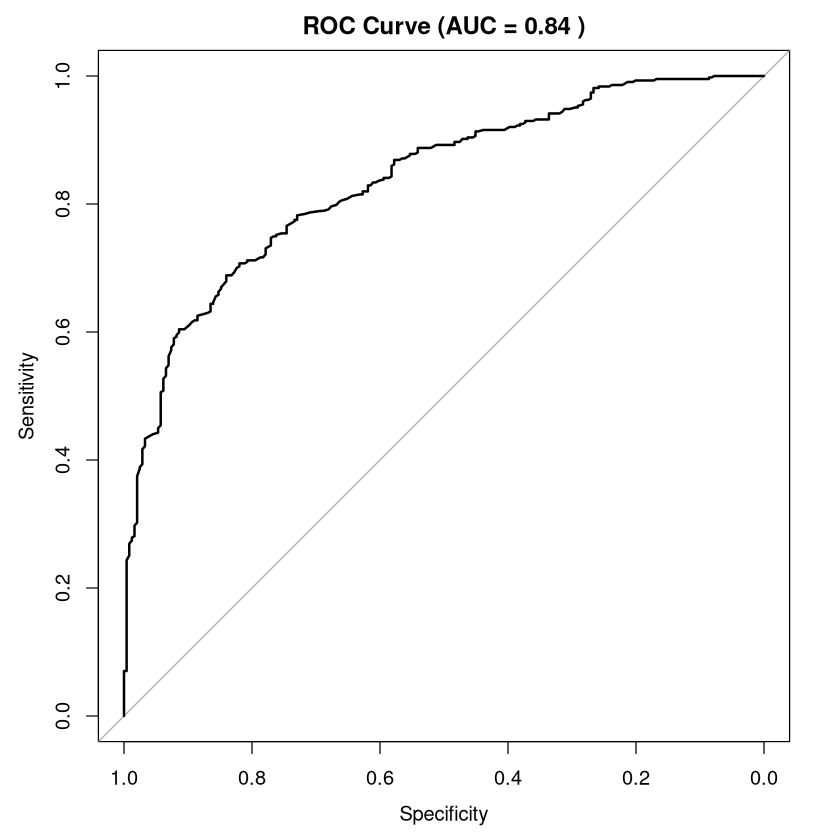

In [65]:
predictions <- predict(rf_model, test_data)
probabilities <- predict(rf_model, test_data, type = "prob")

# Confusion matrix
conf_matrix <- confusionMatrix(predictions, test_data$labels)
print(conf_matrix)

# ROC curve and AUC
roc_obj <- roc(test_data$labels, probabilities[, "Cardiotoxic"])
auc_value <- auc(roc_obj)
plot(roc_obj, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"))

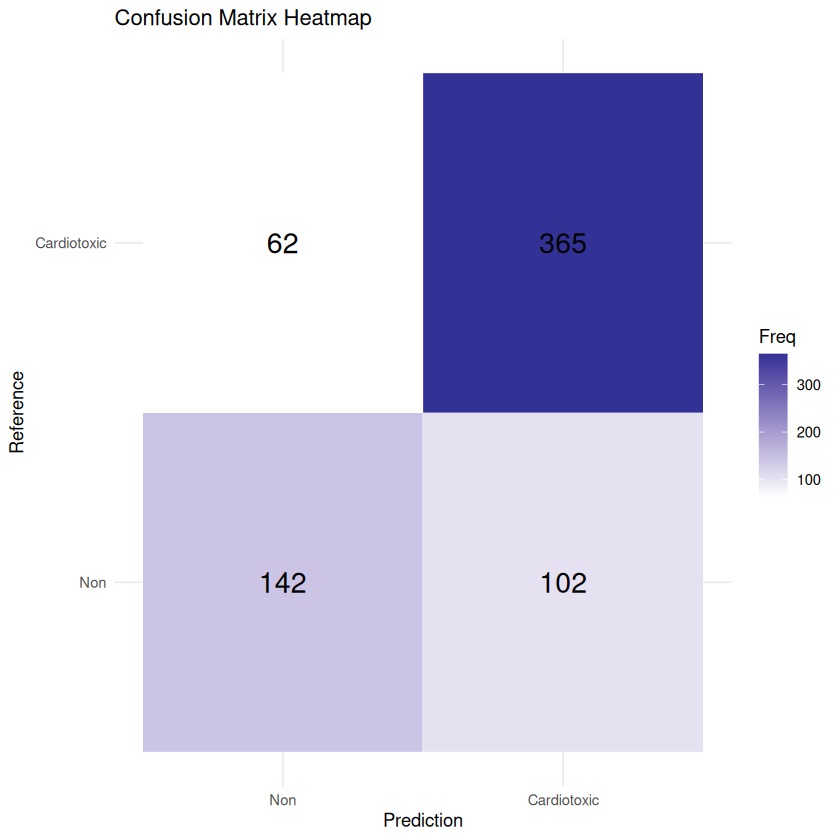

In [66]:
# Convert to data frame
cm_df <- as.data.frame(conf_matrix$table)

# Confusion Matrix Heatmap
ggplot(cm_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 6) +
  scale_fill_gradient(low = "white", high = "#323296") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap")

rf variable importance

                   Overall
`Citrulline-D4`     100.00
Lactate              68.70
`Arachidonic Acid`   42.96
Lactate.D3           34.00
Thymidine            23.91
Thymidine.D4         20.01
`2'-deoxycytidine`    0.00


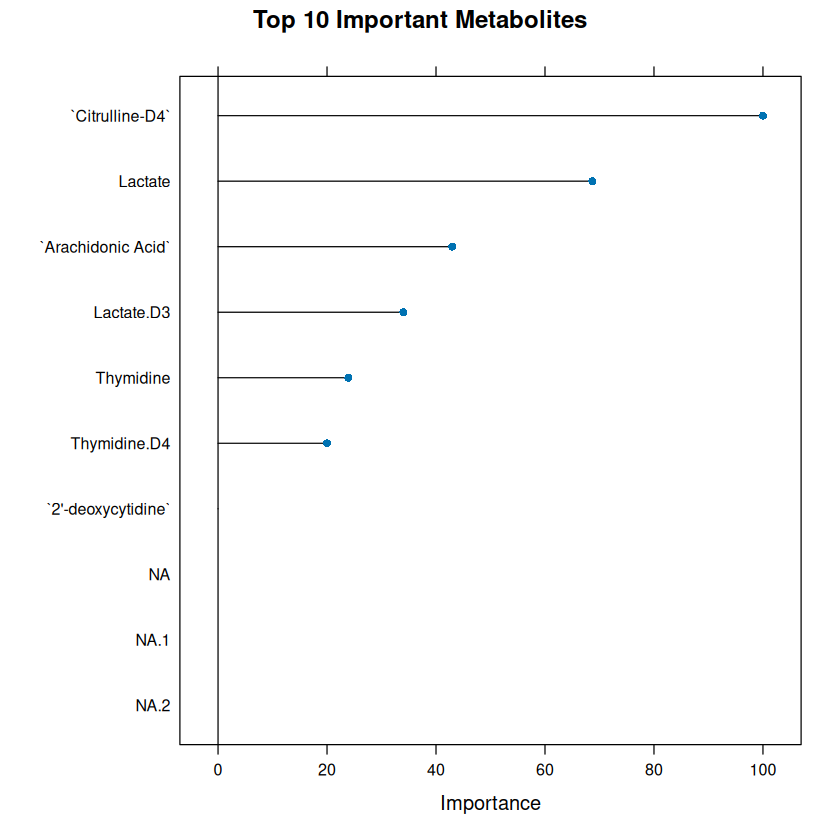

In [67]:
# Get feature importance
importance <- varImp(rf_model)
plot(importance, top = 10, main = "Top 10 Important Metabolites")

print(importance)

##### **SAVE MODEL FOR FUTURE REFERENCE**

In [68]:
# Save the model
saveRDS(rf_model, file="/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/models/rf_cardiotoxicity_model.rds")

# Load and predict on new data (example)
# new_data <- read.csv("new_metabolomics_data.csv") # Format like data_scaled
# new_predictions <- predict(rf_model, new_data)